In [48]:
from mesa import Agent, Model

from mesa.time import RandomActivation

from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

import time
import datetime

In [49]:
class Robot(Agent):
    def __init__(self, unique_id, model, x, y, width, height, xtarget):
        super().__init__(unique_id, model)

        self.pos = np.array((x,y), dtype = int)
        vx = np.random.randint(2)
        vy = np.random.randint(2)
        self.vel = np.array((vx, vy), dtype = int)
        self.dchoice = []
        self.box = None
        self.width = width
        self.height = height
        self.movements = 0
        self.target = np.array((xtarget, height - 1), dtype = int)
        
    def step(self):
        self.stay_inside()
        self.update_target()
        
        if self.box == None:
            self.move_robot()
            self.get_box()
            self.pos = self.pos + self.vel
            self.movements += 1
        else:
            if self.pos[1] > 1 and self.pos[0] > 1:
                self.dchoice = ["down"]
            self.follow_path()
            self.move_robot()
            self.box.vel = self.vel
            self.leave_box()
            self.pos = self.pos + self.vel
            self.movements += 1
            
    def move_robot(self):
        d = np.random.choice(self.dchoice)
        if d == 'up':
            self.vel = np.array((0, 1), dtype = int)
        elif d == 'down':
            self.vel = np.array((0, -1), dtype = int)
        elif d == 'left':
            self.vel = np.array((-1, 0), dtype = int)
        elif d == 'right':
            self.vel = np.array((1, 0), dtype = int)
            
    def stay_inside(self):
        self.dchoice = ["up", "down", "left", "right"]
        
        if self.pos[0] >= self.width - 1:
            self.dchoice.remove("right")
        elif self.pos[0] <= 1:
            self.dchoice.remove("left")

        if self.pos[1] >= self.height - 1:
            self.dchoice.remove("up")
        elif self.pos[1] <= 1:
            self.dchoice.remove("down")
            
    def get_box(self):
        for box in model.boxes.agents:
            if self.pos[0] == box.pos[0] and self.pos[1] == box.pos[1] and box.in_place == False:
                box.moving = True
                self.box = box
                self.box.vel = self.vel
    
    def update_target(self):
        for box in model.finished_boxes:
            if box.pos[0] == self.target[0] and box.pos[1] == self.target[1]:
                self.target[1] -= 1
                
        if self.target[1] < self.height - 5:
            self.target[1] -= 2
            
        if self.target[1] < 1:
            self.target[1] = 1
            self.target[0] += 1
            
    def follow_path(self):    
        if self.pos[1] == 1 and 1 < self.pos[0] <= self.width - 1:
            self.dchoice = ["left"]
        elif self.pos[0] == 1 and 1 <= self.pos[1] < self.target[1]:
            self.dchoice = ["up"]
        elif self.pos[1] == self.target[1] and 1 <= self.pos[0] < self.target[0]:
            self.dchoice = ["right"]
        elif self.pos[0] == self.target[0] and self.target[1] < self.pos[1] <= self.height - 1:  
            self.dchoice = ["down"]
                
    def leave_box(self):
        if self.pos[0] == self.target[0]:
            if self.pos[1] == self.target[1]:
                model.finished_boxes.append(self.box)
                self.box.moving = False
                self.box.in_place = True
                self.box = None
            

In [50]:
class Caja(Agent):
    def __init__(self, unique_id, model, x, y, width, height):
        super().__init__(unique_id, model)
        
        self.pos = np.array((x, y), dtype = int)
        
        self.vel = np.array((0,0), dtype = int)
        
        self.moving = False
        self.in_place = False
        
        self.width = width
        self.height = height
       
        
    def step(self):
        if self.moving == True and self.in_place == False:
            self.pos = self.pos + self.vel

In [51]:
def get_robots(model):
    result = []
    for agent in model.robots.agents:
        result.append(agent.pos)
    result = np.asarray(result)
    return result

def get_boxes(model):
    result = []
    for box in model.boxes.agents:
        result.append(box.pos)
    result = np.asarray(result)
    return result

class Modelo(Model):
    def __init__(self, N, width, height, k):
        self.nboxes = k
        self.nrobots = N
        self.robots = RandomActivation(self)
        self.boxes = RandomActivation(self)
        self.finished_boxes = []
        self.end = False

        temp = []
        i = 0
        while i in range(self.nboxes):
            x = np.random.randint(1, width - 2)
            y = np.random.randint(1, height - 2)
            pos = [x,y]
            
            if pos in temp:
                continue
            
            box = Caja(i, self, x, y, width, height)
            self.boxes.add(box)
            temp.append(pos)
            i += 1
        
        i = 0
        target = 1
        while i in range(self.nrobots):
            x = np.random.randint(1, width - 1)
            y = np.random.randint(1, height - 1)
            pos = [x, y]
            
            if pos in temp:
                continue
            
            r = Robot(i, self, x, y, width, height, target)
            self.robots.add(r)
            target += 2
            temp.append(pos)
            i += 1
            
        self.datacollector = DataCollector(model_reporters = {"Robots" : get_robots, "Boxes" : get_boxes})
            
    def step(self):
        self.robots.step()
        self.boxes.step()
        self.datacollector.collect(self)
        
    def get_movements(self):
        total = 0
        for agent in model.schedule.agents:
            total += agent.movimientos
        return total

In [52]:
WIDTH = 15
HEIGHT = 15
K = 20
N = 5
MAX_ITERATIONS = 500

start_time = time.time()

model = Modelo(N, WIDTH, HEIGHT, K)
steps = 0
for i in range(MAX_ITERATIONS):
    model.step()
    steps += 1
    if len(model.finished_boxes) == model.nboxes:
            self.end = True
print('Tiempo total = ', str(datetime.timedelta(seconds=(time.time() - start_time))))

In [53]:
all_positions = model.datacollector.get_model_vars_dataframe()

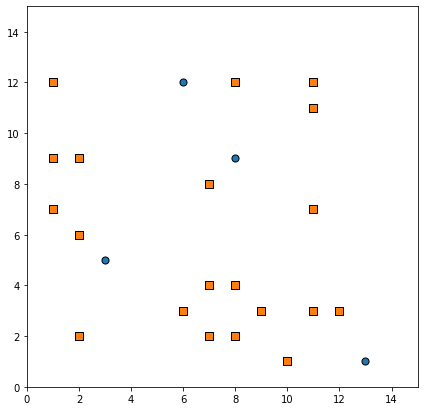

In [54]:
fig, ax = plt.subplots(figsize=(7,7))
scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1], 
                  s=50, cmap="jet", edgecolor="k",  marker="o")

boxes = ax.scatter(all_positions.iloc[0][1][:,0], all_positions.iloc[0][1][:,1], 
                  s=80, cmap="jet", edgecolor="k", marker="s")


ax.axis([0, WIDTH, 0, HEIGHT])
def update(frame_number):
    scatter.set_offsets(all_positions.iloc[frame_number][0])
    boxes.set_offsets(all_positions.iloc[frame_number][1])
    return scatter

anim = animation.FuncAnimation(fig, update, frames=MAX_ITERATIONS)

In [55]:
anim